In [375]:
import pandas as pd
# import modin.pandas as mpd
import numpy as np
import datetime
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import mplfinance as mpf
from multiprocessing import Pool
from contextlib import contextmanager
from joblib import Parallel, delayed
from IPython.display import clear_output
# import dill as pickle
import pickle
import time

In [376]:
# causis api
from causis_api.const import get_version
from causis_api.const import login
login.username = 'shuai.song'
login.password = 'Tsinghua2022'
login.version = get_version()
from causis_api.data import *
from causis_api.tool import *

### Data Preparation

In [377]:
commodities = {
            'rb':{'multiplier':10,'mintick':1,'exchange':'SHF'},
            'hc':{'multiplier':10,'mintick':1,'exchange':'SHF'},
            'i':{'multiplier':100,'mintick':0.5,'exchange':'DCE'},
            'm':{'multiplier':10,'mintick':1,'exchange':'DCE'},
            'pp':{'multiplier':5,'mintick':1,'exchange':'DCE'},
            'MA':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'bu':{'multiplier':10,'mintick':2,'exchange':'SHF'},
            'l':{'multiplier':5,'mintick':5,'exchange':'DCE'},
            'p':{'multiplier':10,'mintick':2,'exchange':'DCE'},
            'v':{'multiplier':5,'mintick':5,'exchange':'DCE'},
            'CF':{'multiplier':5,'mintick':5,'exchange':'CZC'},
            'OI':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'SR':{'multiplier':10,'mintick':1,'exchange':'CZC'},
            'TA':{'multiplier':5,'mintick':2,'exchange':'CZC'},
            'SA':{'multiplier':20,'mintick':1,'exchange':'CZC'},
} 

In [378]:
# Periods_5min = []
# F_data_5min = {}

# Periods_D = []
# F_data_D = {}
# for symbol in tqdm(commodities.keys(), desc='Data Accessing'):
#     c = f"R.CN.{commodities[symbol]['exchange']}.{symbol}.0004"

#     com_5min = get_price(c, '2010-01-01', '2022-06-25', 'minute5')
#     com_5min[['OPEN', 'HIGH', 'CLOSE', 'LOW']] = com_5min[['OPEN', 'HIGH', 'CLOSE', 'LOW']].astype('float64')
#     com_5min[['SYMBOL', 'CLOCK']] =  com_5min[['SYMBOL', 'CLOCK']].astype('string')
#     Periods_5min.append((com_5min['CLOCK'].iloc[0], com_5min['CLOCK'].iloc[-1]))
#     F_data_5min[symbol] = com_5min

#     com_D = get_price(c, '2010-01-01', '2022-06-25')
#     com_D[['OPEN', 'HIGH', 'CLOSE', 'LOW']] = com_D[['OPEN', 'HIGH', 'CLOSE', 'LOW']].astype('float64')
#     com_D[['SYMBOL', 'CLOCK']] =  com_D[['SYMBOL', 'CLOCK']].astype('string')
#     Periods_D.append((com_D['CLOCK'].iloc[0], com_D['CLOCK'].iloc[-1]))
#     F_data_D[symbol] = com_D

# with open('./dataset/F_data_5min.pkl', 'wb') as f:
#     pickle.dump(F_data_5min, f)

# with open('./dataset/F_data_D.pkl', 'wb') as f:
#     pickle.dump(F_data_D, f)

In [379]:
F_data_5min = pd.read_pickle('./dataset/F_data_5min.pkl')
F_data_D = pd.read_pickle('./dataset/F_data_D.pkl')

Try Diffierent Timeframes:
+ 1 minutes: there may be more trading opportunities while also exits more noise. It's always okay if we can grab the correct opportunity ~5min later. But it's overwhelming to trigger a wrong signal whose cost is at least 2*tick.
  

In [902]:
scom = 'rb'
FILTER = True

In [903]:
# 5 MINs
COM_5 = F_data_5min[scom]
COM_D = F_data_D[scom]

COM_5 = COM_5.set_index('CLOCK', drop=False)
COM_5 = COM_5.ffill()

COM_D = COM_D.set_index('CLOCK', drop=False)

COM_5['DATE'] = COM_5['CLOCK'].apply(lambda x: x[:10])

COM_5_VTD = []

for name, g in COM_5.groupby('DATE'):
    COM_5_VTD.append(name)

In [909]:
# BACKTEST_VTD = np.array(COM_5_VTD)
# np.save('./dataset/BACKTEST_VTD.npy', BACKTEST_VTD)

In [910]:
BACKTEST_VTD = np.load('./dataset/BACKTEST_VTD.npy')
BACKTEST_VTD = BACKTEST_VTD.tolist()

### Double SuperTrend Strategy

#### Global Environment Variables

In [851]:
## Macro Trend Indicator
DAY_EMA_S = 60
DAY_EMA_L = 120

## Super Trend Indicator
ATR_WIN_S = 5
STD_MULTIPLIER_S = 2

ATR_WIN_L = 10
STD_MULTIPLIER_L = 3

## BackTest & Simulation Parameters
ACCOUNT = 1e6
REWARD_RATIO = 0.15

## Plot Settings
COLORS = ['darkorange', 'cyan', 'royalblue', 'deeppink', 'indianred', 'limegreen']

#### Technical Features & Signal Triggers

In [868]:
@contextmanager 
def timer(name: str, _align, _log): # ⏱
    s = time.time()
    yield
    elapsed = time.time() - s
    if _log:
        print(f"{ '[' + name + ']' :{_align}} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done | Using {elapsed: .3f} seconds")

In [869]:
def price_adj(stmp, PADJ):
    if PADJ:
        stmp['OPEN_adj'] = round(stmp['OPEN'] * stmp['ADJ'], 2)
        stmp['CLOSE_adj'] = round(stmp['CLOSE'] * stmp['ADJ'], 2)
        stmp['HIGH_adj'] = round(stmp['HIGH'] * stmp['ADJ'], 2)
        stmp['LOW_adj'] = round(stmp['LOW'] * stmp['ADJ'], 2)
    else:
        stmp['OPEN_adj'] = stmp['OPEN'] 
        stmp['CLOSE_adj'] = stmp['CLOSE'] 
        stmp['HIGH_adj'] = stmp['HIGH'] 
        stmp['LOW_adj'] = stmp['LOW'] 

    return stmp

In [873]:
def technical_analysis(stmp, logger = True, PADJ=True):
    stmp = stmp.loc[~stmp['CLOCK'].duplicated()]
    stmp = price_adj(stmp.copy(deep=True), PADJ)

    with timer('TR', 20, logger):
        ## TR
        TR = []
        TR.append(stmp['HIGH_adj'][0] - stmp['LOW_adj'][0])
        for i in range(1, stmp.shape[0]): 
            TR.append( max( stmp['HIGH_adj'][i]-stmp['LOW_adj'][i], np.abs(stmp['HIGH_adj'][i]-stmp['CLOSE_adj'][i-1]), np.abs(stmp['LOW_adj'][i]-stmp['CLOSE_adj'][i-1])) )

        stmp['TR'] = TR

    ## ATR
    def STD_CAL(atr_win, std_mul, _stmp):
        _stmp['ATR'] = _stmp['TR'].rolling(atr_win, min_periods=1).mean() 

        ## Super Trend
        _stmp['h12'] = (_stmp['HIGH_adj'] + _stmp['LOW_adj'])/2
        _stmp['bub'] = _stmp['h12'] + std_mul*_stmp['ATR']
        _stmp['blb'] = _stmp['h12'] - std_mul*_stmp['ATR']

        UB = []
        LB = []
        UB.append(_stmp['bub'][0])
        LB.append(_stmp['blb'][0])

        for i in range(1, _stmp.shape[0]):
            if _stmp['CLOSE_adj'][i-1] > LB[i-1]:
                LB.append(max(_stmp['blb'][i], LB[i-1]))
            else:
                LB.append(_stmp['blb'][i])
            
            if _stmp['CLOSE'][i-1] < UB[i-1]:
                UB.append(min(_stmp['bub'][i], UB[i-1]))
            else:
                UB.append(_stmp['bub'][i])

        STD = []
        STD.append(np.sign(_stmp['CLOSE_adj'][0] - _stmp['OPEN_adj'][0]))

        for i in range(1, _stmp.shape[0]):
            if _stmp['CLOSE_adj'][i] > UB[i]:
                STD.append(1.0)
            elif _stmp['CLOSE_adj'][i] < LB[i]:
                STD.append(-1.0)
            else:
                STD.append(STD[i-1])

        _stmp['UB'] = UB
        _stmp['LB'] = LB
        _stmp['STD'] = STD
        
        return _stmp['UB'], _stmp['LB'], _stmp['STD']
    
    with timer('Short Super Trend', 20, logger):
        stmp['UB_S'], stmp['LB_S'], stmp['STD_S'] = STD_CAL(ATR_WIN_S, STD_MULTIPLIER_S, stmp.copy(deep=True))

    with timer('Long Super Trend', 20, logger):
        stmp['UB_L'], stmp['LB_L'], stmp['STD_L'] = STD_CAL(ATR_WIN_L, STD_MULTIPLIER_L, stmp.copy(deep=True))

    return stmp

In [878]:
# COM_5 = technical_analysis(COM_5, logger=False, PADJ=False)

Trigger:
+ BUY
  + S_STD turn red from green
  + The fork appears within Orange L_STD 
+ SELL
  + S_STD turn green from red
  + The fork appears within Purple L_STD 

In [800]:
def Double_STD_trigger(stmp):
    tmp = 0.5*(2-np.abs(stmp['STD_S']+stmp['STD_S'].shift(1)))/stmp['STD_S']
    stmp['STD_S_Fork'] = tmp
    stmp['trigger'] = np.zeros(stmp.shape[0])
    
    buy_trigger_condition = (stmp['STD_S_Fork']== 1) & (stmp['STD_L']== 1)
    stmp['trigger'].loc[buy_trigger_condition] = 1

    sell_trigger_condition = (stmp['STD_S_Fork']==-1) & (stmp['STD_L']==-1)
    stmp['trigger'].loc[sell_trigger_condition] = -1
   
    return stmp

In [ ]:
## EMA Filter
def EMA_filter(_stmp):
    # param: Day bars data
    _stmp['EMA_S'] = _stmp['CLOSE'].ewm(span=DAY_EMA_S, adjust=False).mean()
    _stmp['EMA_L'] = _stmp['CLOSE'].ewm(span=DAY_EMA_L, adjust=False).mean()
    Buy_signal_mask = _stmp.loc[_stmp['EMA_S']<_stmp['EMA_L']]['CLOCK'].to_list()
    Sell_signal_mask = _stmp.loc[_stmp['EMA_S']>_stmp['EMA_L']]['CLOCK'].to_list()

    return Buy_signal_mask, Sell_signal_mask

In [801]:
# COM_5 =  Double_STD_trigger(COM_5)

# if FILTER:
#     BSM_EMA, SSM_EMA = EMA_filter(COM_D)
#     COM_5['trigger'].loc[(COM_5['DATE'].apply(lambda x: x in BSM_EMA)) & (COM_5['trigger']==1)] = 0.0
#     COM_5['trigger'].loc[(COM_5['DATE'].apply(lambda x: x in SSM_EMA)) & (COM_5['trigger']==-1)] = 0.0

In [881]:
## All in one Function
def Feature_and_Trigger(COM_5, COM_D, filter):

    COM_5 = technical_analysis(COM_5, logger=False, PADJ=False)
    COM_5 =  Double_STD_trigger(COM_5)

    if filter:
        BSM_EMA, SSM_EMA = EMA_filter(COM_D)
        COM_5['trigger'].loc[(COM_5['DATE'].apply(lambda x: x in BSM_EMA)) & (COM_5['trigger']==1)] = 0.0
        COM_5['trigger'].loc[(COM_5['DATE'].apply(lambda x: x in SSM_EMA)) & (COM_5['trigger']==-1)] = 0.0

    return COM_5, COM_D

#### Simulation

In [804]:
ticker = commodities[scom]['mintick'] * 0

In [929]:
def BUY_Trade(Symbol, tick, logger):
    
    BUY_trigger_list = list(Symbol['trigger'].loc[Symbol['trigger']== 1].index)
    SELL_trigger_list = list(Symbol['trigger'].loc[Symbol['trigger']==-1].index)

    BUY_log = pd.DataFrame(columns=['open_bar', 'close_bar', 'open_price', 'close_price', 'close_reason'])
    clock_rank = Symbol['CLOCK'].to_list()
    
    cal_count = 0

    for i in range(len(BUY_trigger_list)):
        if i >= len(BUY_trigger_list):
            break
        t = BUY_trigger_list[i]

        if logger:
            cal_count += 1
            if cal_count % 10 == 1:
                process = f'{cal_count}/{len(BUY_trigger_list)}'
                print(f"{'[' + process + ']' :12} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done ")
            if cal_count % 100 == 0:
                clear_output()

        open_bar = clock_rank[clock_rank.index(t)+1]
        open_price = Symbol['OPEN'].loc[open_bar] + tick

        loss_cut = Symbol.loc[open_bar]['LB_S']
        profit_cut = Symbol.loc[open_bar]['OPEN'] * (1 + REWARD_RATIO) 

        if Symbol['CLOCK'].loc[t:].loc[Symbol['trigger']==-1].shape[0]: # fork change coming, interrupt the simulation
            close_bar =  clock_rank[min(clock_rank.index(Symbol['CLOCK'].loc[t:].loc[Symbol['trigger']== -1][0])+1, len(clock_rank)-1)]
        else:
            close_bar = clock_rank[-1]

        for i in range(1, int((pd.to_datetime(close_bar) - pd.to_datetime(t)).total_seconds()/60)):
            observation_bar = clock_rank[min(clock_rank.index(open_bar)+i, len(clock_rank)-1)]

            if observation_bar in BUY_trigger_list:
                loss_cut = Symbol.loc[observation_bar]['LB_S']
                del BUY_trigger_list[BUY_trigger_list.index(observation_bar)]

            if observation_bar in SELL_trigger_list:
                loss_cut = Symbol.loc[observation_bar]['UB_S']            

            if (Symbol['LOW'].loc[observation_bar] <= loss_cut):
                close_bar = clock_rank[clock_rank.index(observation_bar)+1]
                close_reason = 'Loss_Cut'
                break

            if (Symbol['HIGH'].loc[observation_bar] >= profit_cut):
                close_bar = clock_rank[clock_rank.index(observation_bar)+1]
                close_reason = 'Profit_Cut'
                break

        close_price = Symbol['OPEN'].loc[close_bar] - tick

        BUY_log.loc[BUY_log.shape[0]] = [open_bar, close_bar, open_price, close_price, close_reason]

    BUY_log['gain'] = BUY_log['close_price'] - BUY_log['open_price']
    BUY_log['signal'] = 'BUY'

    return BUY_log

In [865]:
## plot buy signal
# plt.title(f'BUY Delta Price Cumsum ({scom}, {TICK} tick)')
# BUY_log['gain'].cumsum().plot()

In [928]:
def SELL_Trade(Symbol, tick, logger):
    
    BUY_trigger_list = list(Symbol['trigger'].loc[Symbol['trigger']== 1].index)
    SELL_trigger_list = list(Symbol['trigger'].loc[Symbol['trigger']==-1].index)

    SELL_log = pd.DataFrame(columns=['open_bar', 'close_bar', 'open_price', 'close_price'])
    clock_rank = Symbol['CLOCK'].to_list()
    cal_count = 0

    # for t in tqdm(BUY_trigger_list[:], desc='BUY Simulation'):
    for i in range(len(SELL_trigger_list)):
        if i >= len(SELL_trigger_list):
            break
        t = SELL_trigger_list[i]
        
        if logger:
            cal_count += 1
            if cal_count % 10 == 1:
                process = f'{cal_count}/{len(SELL_trigger_list)}'
                print(f"{'[' + process + ']' :12} | {time.strftime('%Y-%m-%d %H:%M:%S')} Done ")
            if cal_count % 100 == 0:
                clear_output()

        open_bar = clock_rank[clock_rank.index(t)+1]
        open_price = Symbol['OPEN'].loc[open_bar] - tick

        loss_cut = Symbol.loc[open_bar]['UB_S']
        profit_cut = Symbol.loc[open_bar]['OPEN'] * (1 - REWARD_RATIO) 

        if Symbol['CLOCK'].loc[t:].loc[Symbol['trigger']== 1].shape[0]: # fork change coming, interrupt the simulation
            close_bar =  clock_rank[min(clock_rank.index(Symbol['CLOCK'].loc[t:].loc[Symbol['trigger']== 1][0])+1, len(clock_rank)-1)]
        else:
            close_bar = clock_rank[-1]

        for i in range(1, int((pd.to_datetime(close_bar) - pd.to_datetime(t)).total_seconds()/60)):
            observation_bar = clock_rank[min(clock_rank.index(open_bar)+i, len(clock_rank)-1)]

            if observation_bar in SELL_trigger_list:
                loss_cut = Symbol.loc[observation_bar]['UB_S']
                del SELL_trigger_list[SELL_trigger_list.index(observation_bar)]

            if observation_bar in BUY_trigger_list:
                loss_cut = Symbol.loc[observation_bar]['LB_S']            

            if (Symbol['HIGH'].loc[observation_bar] >= loss_cut) or (Symbol['LOW'].loc[observation_bar] <= profit_cut):
                close_bar = clock_rank[min(clock_rank.index(observation_bar)+1,len(clock_rank)-1)]
                break

        close_price = Symbol['OPEN'].loc[close_bar] + tick

        SELL_log.loc[SELL_log.shape[0]] = [open_bar, close_bar, open_price, close_price]

    SELL_log['gain'] = SELL_log['open_price'] - SELL_log['close_price']
    SELL_log['signal']= 'SELL'

    return SELL_log

In [861]:
# plt.title(f"SELL Delta Price Cumsum ({scom}, {TICK} tick)")
# SELL_log['gain'].cumsum().plot()

In [895]:
def log_patch(trading_log):
    ## Drop NaN error dates
    for d1 in trading_log.loc[trading_log['close_price'].apply(lambda x: np.isnan(x))].index:
        trading_log.drop(d1, inplace=True)

    ## Drop Date collapse
    for d2 in trading_log.loc[trading_log['open_bar']<trading_log['close_bar'].shift(1)].index:
        trading_log.drop(d2, inplace=True)

    return trading_log

In [912]:
def Trading_trace(COM_5, tick, COM_5_VTD):
    ## trigger execution
    BUY_log = BUY_Trade(COM_5, tick, logger=False) 
    SELL_log = SELL_Trade(COM_5, tick, logger=False)

    buy = BUY_log.set_index('open_bar', drop=False)
    sell = SELL_log.set_index('open_bar', drop=False)

    trading_log_buy = buy.sort_index()
    trading_log_sell = sell.sort_index()

    trading_log_all = buy.append(sell)
    trading_log_all = trading_log_all.sort_index()

    ## patch some potential error
    trading_log_buy = log_patch(trading_log_buy)
    trading_log_sell = log_patch(trading_log_sell)
    trading_log_all = log_patch(trading_log_all)

    ## create trade date columns
    def Date_Belong(clock):
        if clock[11:] < '21:00:00':
            return clock[:10]
        else:
            return COM_5_VTD[min(COM_5_VTD.index(clock[:10])+1, len(COM_5_VTD)-1)]

    trading_log_buy['open_date'] = trading_log_buy['open_bar'].apply(lambda x: Date_Belong(x))
    trading_log_buy['close_date'] = trading_log_buy['close_bar'].apply(lambda x: Date_Belong(x))

    trading_log_sell['open_date'] = trading_log_sell['open_bar'].apply(lambda x: Date_Belong(x))
    trading_log_sell['close_date'] = trading_log_sell['close_bar'].apply(lambda x: Date_Belong(x))

    trading_log_all['open_date'] = trading_log_all['open_bar'].apply(lambda x: Date_Belong(x))
    trading_log_all['close_date'] = trading_log_all['close_bar'].apply(lambda x: Date_Belong(x))

    return [trading_log_buy, trading_log_sell, trading_log_all]

In [814]:
# SELL_log['signal']= 'SELL'
# BUY_log['signal'] = 'BUY'

# buy = BUY_log.set_index('open_bar', drop=False)
# sell = SELL_log.set_index('open_bar', drop=False)

# trading_log_buy = buy.sort_index()
# trading_log_sell = sell.sort_index()

# trading_log_all = buy.append(sell)
# trading_log_all = trading_log_all.sort_index()

In [860]:
# fig, axes = plt.subplots(figsize=(10, 5))
# plt.title('Simulation Gain Cumsum {scom}, 1.5tick)')
# trading_log_all['gain'].cumsum().plot()

### BackTest

In [897]:
def Dominant_change(scom):
    Dominant = get_dominant_contracts(f"R.CN.{commodities[scom]['exchange']}.{scom}.0004", COM_5_VTD[0], COM_5_VTD[-1])

    Dominant['last_dc'] = Dominant['ProductCode'].shift(1)
    Dominant['Date'] = Dominant['Date'].apply(lambda x: x[:4]+'-'+x[4:6]+'-'+x[6:8])

    return Dominant.loc[(Dominant['ProductCode']!=Dominant['last_dc'])][1:]


In [818]:
INIT_CAP = 1e8

In [966]:
def Simulation(Balance, COM_5, trading_log, SYM_VTD, dc_change):
    # for i in tqdm(range(trading_log.shape[0]), desc='Simulation...'):
    for i in range(trading_log.shape[0]):
        entry = trading_log.iloc[i]

        if entry['open_date'] == entry['close_date']: # open and close position in the same day
            OPEN_POS_VOL = int(INIT_CAP/(entry['open_price']*commodities[scom]['multiplier'])) # setting the allocatable money
            Balance['interday_profit'].loc[entry['open_date']] += entry['gain'] * OPEN_POS_VOL * commodities[scom]['multiplier']

        else:# holding position for a period
            pos_dir = 1 if entry['signal'] == 'BUY' else -1
            OPEN_POS_VOL = int(INIT_CAP/(entry['open_price']*commodities[scom]['multiplier'])) 

            period_start = entry['open_date']
            period_end   = SYM_VTD[SYM_VTD.index(entry['close_date'])-1]

            # gain or loss caused by position open
            delta_price = COM_5['CLOSE'].loc[period_start+' 15:00:00'] - entry['open_price']
            Balance['holding_pos'].loc[entry['open_date']] = pos_dir * OPEN_POS_VOL
            Balance['holding_profit'].loc[entry['open_date']] += pos_dir * OPEN_POS_VOL * delta_price * commodities[scom]['multiplier']


            # holding period value fluctuation
            for i in range(SYM_VTD.index(entry['open_date'])+1, SYM_VTD.index(entry['close_date'])):
                delta_price = COM_5['CLOSE'].loc[SYM_VTD[i]+' 15:00:00'] - COM_5['CLOSE'].loc[SYM_VTD[i-1]+' 15:00:00'] 
                Balance['holding_pos'].loc[SYM_VTD[i]] = pos_dir * OPEN_POS_VOL
                Balance['holding_profit'].loc[SYM_VTD[i]] += pos_dir * OPEN_POS_VOL * delta_price * commodities[scom]['multiplier']

            delta_price = entry['close_price'] - COM_5['CLOSE'].loc[period_end+' 15:00:00']
            Balance['holding_pos'].loc[entry['close_date']] = pos_dir * OPEN_POS_VOL
            Balance['holding_profit'].loc[entry['close_date']] += pos_dir * OPEN_POS_VOL * delta_price * commodities[scom]['multiplier']

    # for i in tqdm(range(dc_change.shape[0]), desc='Dominant Contracts Change'):
    for i in range(dc_change.shape[0]):
        try:
            entry = dc_change.iloc[i]
            nc = get_price(entry['ProductCode'], entry['Date'], entry['Date'])
            np = nc['OPEN'] # new contract price

            oc = get_price(entry['last_dc'], entry['Date'], entry['Date'])
            op = oc['OPEN'] # old contract price

            Balance['dc_change_gap'].loc[entry['Date']] += (op - np)*Balance['holding_pos'].loc[entry['Date']]
        except:
            continue # some data is ommited which is not contained in COM_5 either, so just ignore them

    # dc change has no effect
    # Balance['holding_pos'].loc[(Balance['holding_pos']!=0) & (pd.Series(Balance.index).apply(lambda x: x in dc_change['Date'].to_list()))]

    return Balance
 

In [822]:
# Balance_ALL = Simulation(trading_log_all)
# Balance_BUY = Simulation(trading_log_buy)
# Balance_SELL = Simulation(trading_log_sell)

Dominant Contracts Change: 100%|██████████| 24/24 [00:03<00:00,  6.05it/s]


In [ ]:
# Balance = pd.DataFrame()
# Balance = Balance.reindex(BACKTEST_VTD)
# Balance['Account']  = np.zeros(Balance.shape[0])
# Balance['interday_profit'] = np.zeros(Balance.shape[0])
# Balance['holding_profit'] = np.zeros(Balance.shape[0])
# Balance['holding_pos'] = np.zeros(Balance.shape[0])
# Balance['dc_change_gap'] = np.zeros(Balance.shape[0])

# dc_change = Dominant_change(scom)

# Balance_ALL = Simulation(Balance, COM_5, trading_log_all, COM_5_VTD, dc_change)

In [967]:
def Simulation_all_in_one(scom, sig_filter, backtest_tick, logger=True):

    Balance = pd.DataFrame()
    Balance = Balance.reindex(BACKTEST_VTD)
    Balance['Account']  = np.zeros(Balance.shape[0])
    Balance['interday_profit'] = np.zeros(Balance.shape[0])
    Balance['holding_profit'] = np.zeros(Balance.shape[0])
    Balance['holding_pos'] = np.zeros(Balance.shape[0])
    Balance['dc_change_gap'] = np.zeros(Balance.shape[0])

    ## 5 MINs Data Preparation
    COM_5 = F_data_5min[scom]
    COM_D = F_data_D[scom]

    COM_5 = COM_5.set_index('CLOCK', drop=False)
    COM_5 = COM_5.ffill()

    COM_D = COM_D.set_index('CLOCK', drop=False)

    COM_5['DATE'] = COM_5['CLOCK'].apply(lambda x: x[:10])

    COM_5_VTD = []

    for name, g in COM_5.groupby('DATE'):
        COM_5_VTD.append(name)
    with timer('Feature and Trigger', 25, logger):
        COM_5, COM_D = Feature_and_Trigger(COM_5, COM_D, filter=sig_filter)

    TICK = commodities[scom]['mintick'] * backtest_tick

    with timer('Trading trace', 25, logger):
        logs = Trading_trace(COM_5, TICK, COM_5_VTD)

    dc_change = Dominant_change(scom)
    with timer('Trading Simulation', 25, logger):
        Balance = Simulation(Balance, COM_5, logs[2], COM_5_VTD, dc_change)

    Balance['d_gain'] = Balance['interday_profit'] + Balance['holding_profit'] +  Balance['dc_change_gap']
    Balance['Pnl'] = Balance['d_gain'].cumsum()/INIT_CAP + 1
    
    return (Balance, logs)


In [968]:
tup = Simulation_all_in_one('rb', sig_filter=False, backtest_tick=0)

[Feature and Trigger]     | 2022-08-19 15:04:37 Done | Using  16.517 seconds
[Trading trace]           | 2022-08-19 15:10:25 Done | Using  347.969 seconds
[Trading Simulation]      | 2022-08-19 15:10:34 Done | Using  9.187 seconds


In [ ]:
# BATCH_SIZE = 128 # Do not put all eggs in one signal bucket
# res = []
# ## Parallel BackTest
# tasks = []
# for i in range(3, (len(Weight_Matrix.columns)//BATCH_SIZE + 1)):
#     with timer(f'Batch {i}: {BATCH_SIZE*i:3} -- {min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))-1:3}', True):
#         for col in Weight_Matrix.columns[BATCH_SIZE*i:min(len(Weight_Matrix.columns), BATCH_SIZE*(i+1))]:
#             stmp_ = Base_Pos[col]
#             tasks.append(delayed(one_stock_simulation)(col, stmp_))

#         multi_work = Parallel(n_jobs=-1)
#         res += multi_work(tasks)

In [959]:
balance, sym_logs = Simulation_all_in_one(sig_filter=False, backtest_tick=0)

======= rb:1/15 =======
[Feature and Trigger]     | 2022-08-19 13:41:21 Done | Using  16.192 seconds
[Trading trace]           | 2022-08-19 13:47:00 Done | Using  339.031 seconds
[Trading Simulation]      | 2022-08-19 13:47:15 Done | Using  14.977 seconds
======= hc:1/15 =======
[Feature and Trigger]     | 2022-08-19 13:47:27 Done | Using  12.040 seconds
[Trading trace]           | 2022-08-19 13:50:25 Done | Using  177.644 seconds
[Trading Simulation]      | 2022-08-19 13:50:31 Done | Using  5.728 seconds
======= i:1/15 =======
[Feature and Trigger]     | 2022-08-19 13:50:44 Done | Using  13.099 seconds
[Trading trace]           | 2022-08-19 13:53:56 Done | Using  191.759 seconds
[Trading Simulation]      | 2022-08-19 13:54:01 Done | Using  5.017 seconds
======= m:1/15 =======
[Feature and Trigger]     | 2022-08-19 13:54:18 Done | Using  16.789 seconds
[Trading trace]           | 2022-08-19 14:00:27 Done | Using  368.526 seconds
[Trading Simulation]      | 2022-08-19 14:00:38 Done | Us

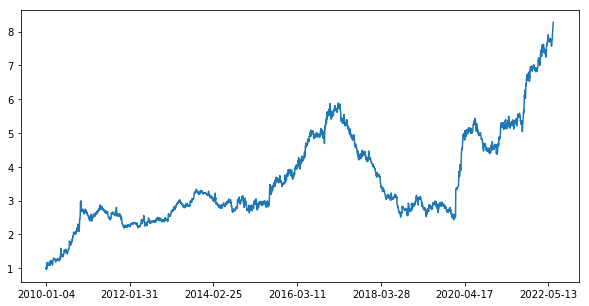

In [960]:
fig, axes = plt.subplots(figsize=(10, 5))
balance['Pnl'].plot()

In [964]:
def profitable_analysis(_pnl):
    Annual_r = (_pnl.diff()/_pnl.shift(1)).mean()*252
    Std = (_pnl.diff()/_pnl.shift(1)).std()*np.sqrt(252)
    Sharpe = Annual_r / Std
    MaxDrawdown = (1 - list(_pnl)/pd.Series(list(_pnl.rolling(len(_pnl)))).apply(lambda x: x.max())).max()
    Calmar = Annual_r / MaxDrawdown
    return Annual_r, Std, Sharpe, MaxDrawdown, Calmar

In [965]:
profitable_analysis(balance['Pnl'])

(0.2086474634467096,
 0.2610826497084078,
 0.799162501528689,
 0.5869811303052277,
 0.355458553392021)

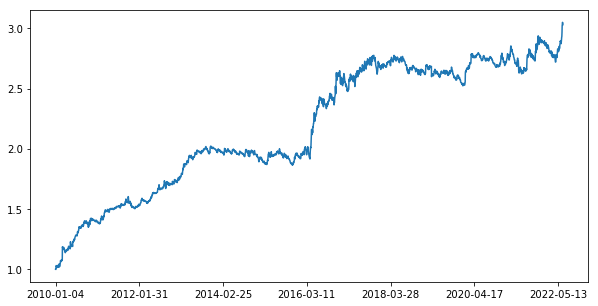

In [952]:
fig, axes = plt.subplots(figsize=(10, 5))
balance['Pnl'].plot()

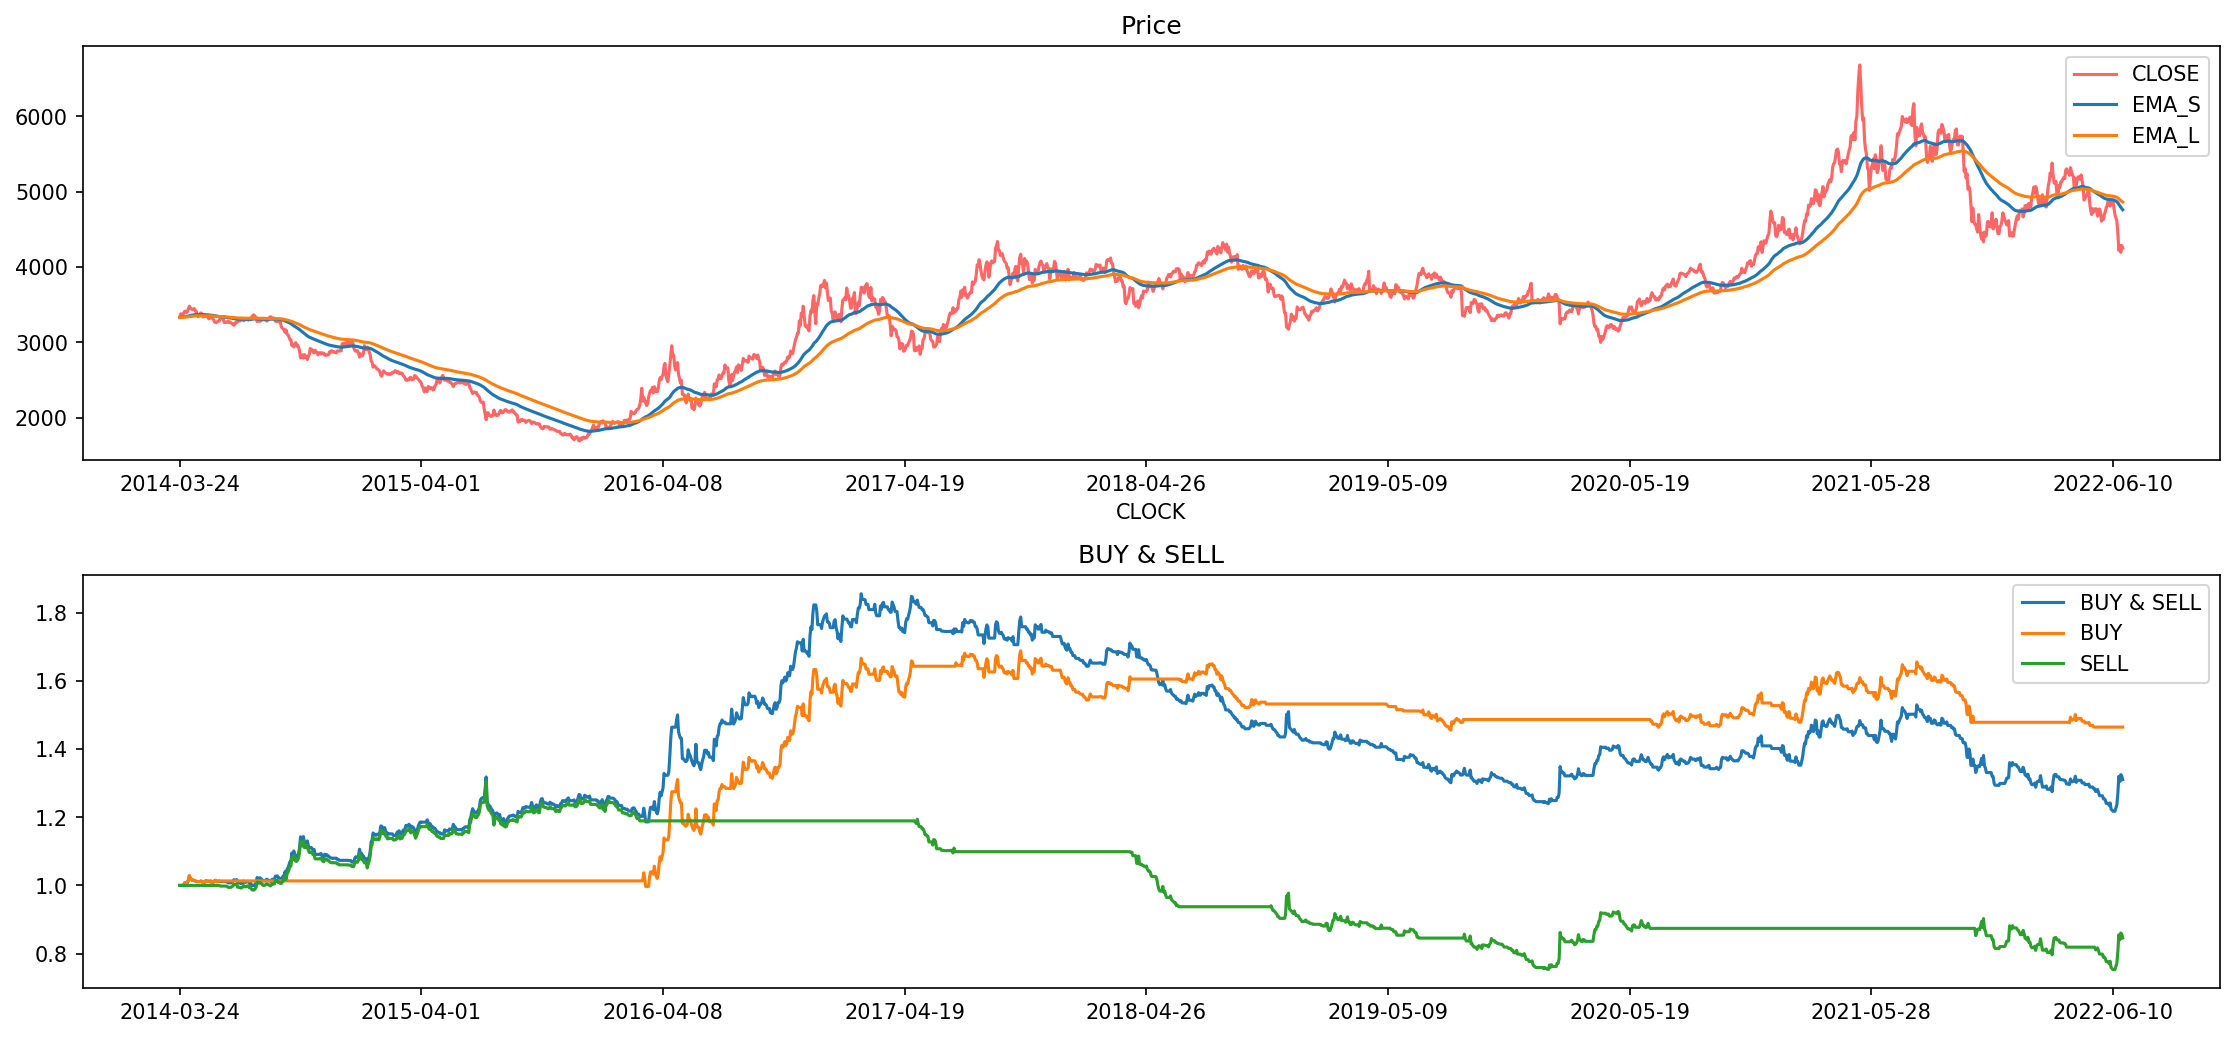

In [823]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 7), dpi=150)

COM_D['CLOSE'].plot(ax=axes[0],color='r', alpha=0.6, label='CLOSE')
if FILTER:
    COM_D['EMA_S'].plot(ax=axes[0], label='EMA_S')
    COM_D['EMA_L'].plot(ax=axes[0], label='EMA_L')
axes[0].set_title('Price')
axes[0].legend()

Balance_ALL['Pnl'][:].plot(ax = axes[1], label='BUY & SELL')
Balance_BUY['Pnl'][:].plot(ax = axes[1], label='BUY')
Balance_SELL['Pnl'][:].plot(ax = axes[1], label='SELL')
axes[1].set_title('BUY & SELL')
axes[1].legend()

plt.tight_layout(True)


In [836]:
trading_log_all['hold_t'] = (trading_log_all['close_bar'].apply(lambda x: pd.to_datetime(x))-trading_log_all['open_bar'].apply(lambda x: pd.to_datetime(x))).apply(lambda x: x.total_seconds()/60)

In [837]:
trading_log_all['hold_t'].describe()

count      840.000000
mean      1916.595238
std       3073.692618
min         10.000000
25%        108.750000
50%        720.000000
75%       2146.250000
max      25605.000000
Name: hold_t, dtype: float64

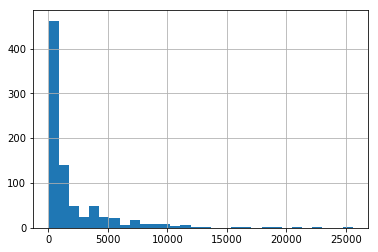

In [838]:
trading_log_all['hold_t'].hist(bins=30)

In [839]:
qc = 0
GN = 10
curs = []
for i in range(1, 1+GN):
    qc = i/10
    curs.append(int(trading_log_all['hold_t'].quantile(qc)))

curs = [0.] + curs

In [840]:
curs

[0.0, 30, 65, 185, 420, 720, 1140, 1519, 3185, 5635, 25605]

In [841]:
def group(x):
    for i in range(GN):
        if (curs[i] < x) and (x <= curs[i+1]):
            return i + 1 

In [842]:
trading_log_all['hold_t_g'] = trading_log_all['hold_t'].apply(lambda x: group(x))

In [843]:
log_g = trading_log_all.groupby('hold_t_g')

In [844]:
win_rate = []
win_loss_r = []
for id, df in log_g:
    win_rate.append(df.loc[df['gain']>0].shape[0] / df.shape[0])
    win_loss_r.append(-1 * df['gain'].loc[df['gain']>0].sum() / df['gain'].loc[df['gain']<0].sum())

In [845]:
Hold_quantile = pd.DataFrame()
Hold_quantile = Hold_quantile.reindex(curs[1:])
Hold_quantile['win_rate'] = win_rate
Hold_quantile['win-loss_ratio'] = win_loss_r

In [849]:
trading_log_all.loc[trading_log_all['gain']>0].shape[0]/trading_log_all.shape[0]

0.2571428571428571

In [850]:
trading_log_all['gain'].loc[trading_log_all['gain']>0].sum()/trading_log_all['gain'].loc[trading_log_all['gain']<0].sum() *-1

1.0055529847292919

In [846]:
Hold_quantile

,win_rate,win-loss_ratio
30,0.010989,0.008565
65,0.012346,0.007110
185,0.011905,0.001037
420,0.074074,0.031818
720,0.056818,0.029232
1140,0.187500,0.240562
1519,0.457831,1.606287
3185,0.500000,1.424501
5635,0.452381,2.076675
25605,0.821429,13.437276


In [859]:
trading_log_buy

,open_bar,close_bar,open_price,close_price,close_reason,gain,signal,open_date,close_date
open_bar,,,,,,,,,
2014-03-28 13:35:00,2014-03-28 13:35:00,2014-03-28 14:05:00,3376.0,3368.0,Loss_Cut,-8.0,BUY,2014-03-28,2014-03-28
2014-03-28 14:45:00,2014-03-28 14:45:00,2014-04-15 09:30:00,3376.0,3432.0,Loss_Cut,56.0,BUY,2014-03-28,2014-04-15
2014-04-17 13:45:00,2014-04-17 13:45:00,2014-04-17 14:20:00,3426.0,3416.0,Loss_Cut,-10.0,BUY,2014-04-17,2014-04-17
2014-04-24 14:35:00,2014-04-24 14:35:00,2014-04-25 09:35:00,3384.0,3380.0,Loss_Cut,-4.0,BUY,2014-04-24,2014-04-25
2014-04-29 13:40:00,2014-04-29 13:40:00,2014-04-30 09:10:00,3362.0,3360.0,Loss_Cut,-2.0,BUY,2014-04-29,2014-04-30
...,...,...,...,...,...,...,...,...,...
2022-04-21 10:50:00,2022-04-21 10:50:00,2022-04-21 13:40:00,5227.0,5187.0,Loss_Cut,-40.0,BUY,2022-04-21,2022-04-21
2022-04-26 10:55:00,2022-04-26 10:55:00,2022-04-26 14:40:00,4935.0,4909.0,Loss_Cut,-26.0,BUY,2022-04-26,2022-04-26
2022-04-26 21:10:00,2022-04-26 21:10:00,2022-04-27 10:40:00,4946.0,4948.0,Loss_Cut,2.0,BUY,2022-04-27,2022-04-27


### PLOT

In [847]:
def plot_all(COM, t1, t2, PADJ=True):

    P_tmp = price_adj(COM.copy(deep=True), PADJ)

    P_tmp['UB_S'].loc[P_tmp['STD_S']== 1.0] = np.nan # plot upper band during down trend
    P_tmp['LB_S'].loc[P_tmp['STD_S']==-1.0] = np.nan # plot lower band during up trend
    
    P_tmp['UB_L'].loc[P_tmp['STD_L']== 1.0] = np.nan # plot upper band during down trend
    P_tmp['LB_L'].loc[P_tmp['STD_L']==-1.0] = np.nan # plot lower band during up trend

    smp_slice = P_tmp.loc[t1: t2]
    fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize=(50, 20), dpi=100, sharex=True)

    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dr'], color = 'red')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lr'], color = 'pink')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_dg'], color = 'green')
    # axes[0].bar(smp_slice['CLOCK'].to_list(), smp_slice['MACD_lg'], color = 'lightgreen')

    # smp_slice['J'].plot(ax = axes[1], color='black')
    # axes[1].axhline(y=90, color='pink')
    # axes[1].axhline(y=10, color='pink')
    axes[1].bar(smp_slice['CLOCK'].to_list(), smp_slice['VOLUME'], color='purple', alpha=0.6)


 
    smp_slice['UB_S'].plot(ax=axes[2], color='g', linewidth=3.5, linestyle='--')
    smp_slice['LB_S'].plot(ax=axes[2], color='r', linewidth=3.5, linestyle='--')

    smp_slice['UB_L'].plot(ax=axes[2], color='purple', linewidth=2.5, linestyle='-.')
    smp_slice['LB_L'].plot(ax=axes[2], color='orange', linewidth=2.5, linestyle='-.')

  
    sdf = pd.DataFrame()
    sdf['CLOCK'] = smp_slice['CLOCK'].apply(lambda x: pd.to_datetime(x))
    sdf = sdf.set_index('CLOCK')
    sdf['Open'] = smp_slice['OPEN_adj']
    sdf['Close'] = smp_slice['CLOSE_adj']
    sdf['High'] = smp_slice['HIGH_adj']
    sdf['Low'] = smp_slice['LOW_adj']
    sdf['Volume'] = smp_slice['VOLUME']

    mc = mpf.make_marketcolors(up='red', down='green', edge='black')
    s = mpf.make_mpf_style(base_mpf_style='yahoo', marketcolors=mc, y_on_right=False)

    mpf.plot(sdf, ax = axes[2], type='candle', style = s, ylabel='')

    # smp_slice['P_S_EMA'].plot(ax=axes[2], color='orange', alpha=0.6)
    # smp_slice['P_L_EMA'].plot(ax=axes[2], color='purple', alpha=0.6)

    # ax_twin = axes[2].twinx()
    # smp_slice['execution'].plot(ax=ax_twin)

    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()